# Advanced Vizualisation
*Dans ce notebook nous allons créer une figure interactive pour chaque saison qui graphe le taux de tir moyen par heure d'une équipe comparée au taux moyen de la ligue par emplacement*

In [7]:
from ift6758.data import load_cached_season_dataframe, get_player_name
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import plotly.graph_objects as go

# On crée d'abord la demi-patinoire sur laquelle on fait les graphiques

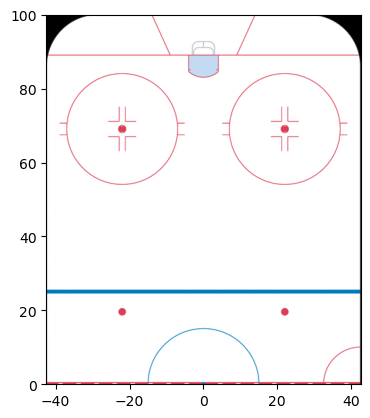

In [35]:
PROJECT_ROOT = Path.cwd().parent  # notebooks -> Project-Hockey
RINK_PATH = PROJECT_ROOT / "figures" / "nhl_rink.png"
HALF_RINK = PROJECT_ROOT / "figures" / "nhl_rink_half.png"

img = np.asarray(Image.open(RINK_PATH).convert('RGB'))

# Coupe l'image en 2
mid_x = img.shape[1] // 2
right_half = img[:, mid_x:]

# k=3 signifie 3 rotations de 90 degrés
rotated_img = np.rot90(right_half, k=1)

Image.fromarray(rotated_img).save(HALF_RINK)

rink_extent = [-42.5, 42.5, 0, 100]
plt.imshow(rotated_img, extent=rink_extent)

# On essaie ensuite pour une saison précise (ici 2017-18). On graphe la densité de tir pour toute la ligue et ensuite la différence pour une équipe particulière (ici Sharks de San Jose)

In [3]:
year = 2017
play_df = load_cached_season_dataframe(year, game_type=2)

# On utilise la valeur absolue de x pour que toutes les données soient sur une moitié de terrain
play_df['x'] = play_df['x'].abs()
play_df.head(10)

,timeInPeriod,period,eventId,teamShot,typeEvent,x,y,shooter,goalie,typeShot,openNet,goalStrenght,gameId,season,gameType
0,00:38,1,54,WPG,shot-on-goal,36.0,-28.0,Josh Morrissey,Frederik Andersen,wrist,False,,2017020001,2017,2
1,00:49,1,55,WPG,shot-on-goal,75.0,1.0,Shawn Matthias,Frederik Andersen,wrist,False,,2017020001,2017,2
2,01:03,1,58,WPG,shot-on-goal,73.0,10.0,Bryan Little,Frederik Andersen,backhand,False,,2017020001,2017,2
3,01:46,1,62,TOR,shot-on-goal,80.0,-3.0,Eric Fehr,Steve Mason,wrist,False,,2017020001,2017,2
4,03:42,1,68,WPG,shot-on-goal,44.0,-21.0,Patrik Laine,Frederik Andersen,snap,False,,2017020001,2017,2
5,03:50,1,69,WPG,shot-on-goal,38.0,-5.0,Dustin Byfuglien,Frederik Andersen,slap,False,,2017020001,2017,2
6,04:30,1,71,WPG,shot-on-goal,47.0,-23.0,Tyler Myers,Frederik Andersen,slap,False,,2017020001,2017,2
7,04:39,1,73,WPG,shot-on-goal,62.0,21.0,Nikolaj Ehlers,Frederik Andersen,wrist,False,,2017020001,2017,2
8,04:49,1,74,WPG,shot-on-goal,36.0,-18.0,Jacob Trouba,Frederik Andersen,wrist,False,,2017020001,2017,2
9,05:11,1,75,TOR,shot-on-goal,60.0,7.0,Patrick Marleau,Steve Mason,snap,False,,2017020001,2017,2


In [4]:
total_games = play_df['gameId'].nunique()

# Définition des limites de la patinoire NHL standard
# X: -100 à 100, Y: -42.5 à 42.5
x_range = np.arange(0, 101, 1)
y_range = np.arange(-42.5, 43.5, 1) # 43.5 pour inclure la limite 42.5

H, x_edges, y_edges = np.histogram2d(
    play_df['x'], 
    play_df['y'], 
    bins=[x_range, y_range]
)

shot_rate_per_hour = H / (total_games * 2) # Hypothèse : Chaque partie dure 1 heure - On multiplie par 2 car 2 équipes par match 

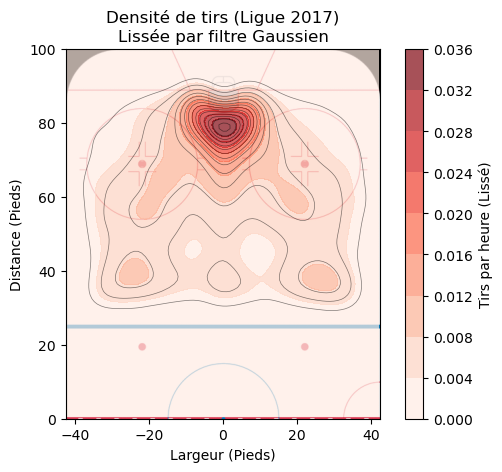

In [14]:
# Lissage gaussien pour avoir un graphique stylé
# sigma=3 veut dire qu'on lisse sur environ 3 pieds de rayon
league_average_smoothed = gaussian_filter(shot_rate_per_hour, sigma=3)

# Fond de patinoire
plt.imshow(rotated_img, extent=rink_extent, zorder=0)

# 3. Affichage en COURBES DE NIVEAU (Contourf)
# On doit calculer le centre des cases pour que contourf ne chiale pas sur les dimensions
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Niveaux : Plus il y a de levels, plus c'est détaillé.
# On utilise smoothed_rate.T pour aligner verticalement
contour = plt.contourf(y_centers, x_centers, league_average_smoothed, 
                       levels=10,            # 15 couches de couleurs
                       cmap='Reds',          # Palette rouge (puisque ce sont des taux positifs)
                       alpha=0.7,            # Transparence
                       zorder=1)

# Optionnel : Ajouter les lignes de contour fines pour faire "carte topo"
plt.contour(y_centers, x_centers, league_average_smoothed, 
            levels=15, colors='black', linewidths=0.5, alpha=0.5, zorder=1)

plt.colorbar(contour, label='Tirs par heure (Lissé)')
plt.title(f"Densité de tirs (Ligue {year})\nLissée par filtre Gaussien")
plt.xlabel("Largeur (Pieds)")
plt.ylabel("Distance (Pieds)")
plt.xlim(-42.5, 42.5)
plt.ylim(0, 100)

plt.show()

In [15]:
team_name = 'SJS'

team_df = play_df[
    (play_df['teamShot'] == team_name) & 
    (play_df['typeEvent'].isin(['shot-on-goal', 'goal']))
].copy()

n_games_team = team_df['gameId'].nunique()

H_team, _, _ = np.histogram2d(
    team_df['x'], 
    team_df['y'], 
    bins=[x_edges, y_edges]
)

team_rate = H_team / n_games_team
team_rate_smoothed = gaussian_filter(team_rate, sigma=3)

diff_rate = team_rate_smoothed - league_average_smoothed

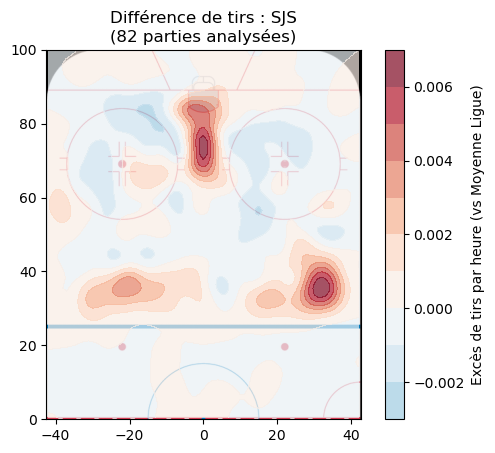

In [17]:
# Fond de patinoire
rink_extent = [-42.5, 42.5, 0, 100]
plt.imshow(rotated_img, extent=rink_extent, zorder=0)

# Calcul des centres pour contourf
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Gestion des couleurs : On veut que 0 soit blanc.
# On cherche la valeur max absolue pour équilibrer le rouge et le bleu
max_val = np.max(np.abs(diff_rate))

# Plot en contours
# cmap='RdBu_r' : Red-Blue reversed (Rouge pour positif/chaud, Bleu pour négatif/froid)
contour = plt.contourf(y_centers, x_centers, diff_rate, 
                       levels=10, 
                       cmap='RdBu_r', 
                       alpha=0.7, 
                       vmin=-max_val, vmax=max_val, # Centre le 0 parfaitement
                       zorder=1)

plt.colorbar(contour, label='Excès de tirs par heure (vs Moyenne Ligue)')
plt.title(f"Différence de tirs : {team_name}\n({n_games_team} parties analysées)")
plt.xlim(-42.5, 42.5)
plt.ylim(0, 100)
plt.show()

# Maintenant on crée l'outil interactif qui permet de choisir quelle équipe on souhaite visualiser pour une saison précise

In [16]:
def compute_team_diff(play_df, team_name, x_edges, y_edges, league_average_smoothed, sigma=3):
    team_df = play_df[
        (play_df["teamShot"] == team_name) &
        (play_df["typeEvent"].isin(["shot-on-goal", "goal"]))
    ].copy()

    n_games_team = team_df["gameId"].nunique()

    H_team, _, _ = np.histogram2d(
        team_df["x"],
        team_df["y"],
        bins=[x_edges, y_edges]
    )

    team_rate = H_team / n_games_team
    team_rate_smoothed = gaussian_filter(team_rate, sigma=sigma)

    diff_rate = team_rate_smoothed - league_average_smoothed
    return diff_rate, n_games_team

In [28]:
def plotly_team_dropdown(team_maps, team_games, x_edges, y_edges, rink_data, year):
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2  # 0..100
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2  # -42.5..42.5

    teams = list(team_maps.keys())
    t0 = teams[0]

    # Échelle par équipe (comme matplotlib max_val = max(abs(diff_rate)))
    team_max = {t: float(np.max(np.abs(team_maps[t]))) for t in teams}
    m0 = team_max[t0]

    fig = go.Figure(go.Contour(
        z=team_maps[t0],
        x=y_centers,   # largeur
        y=x_centers,   # distance
        ncontours=15,
        contours=dict(coloring="heatmap", showlines=True),
        line=dict(width=0.5),
        zmin=-m0, zmax=m0,
        colorscale="RdBu",
        reversescale=True,
        opacity=0.75,
        colorbar=dict(title="Excès tirs vs ligue")
    ))

    # Patinoire en fond
    fig.add_layout_image(dict(
        source=rink_data,
        xref="x", yref="y",
        x=-42.5, y=100,
        sizex=85.0, sizey=100.0,
        sizing="stretch",
        layer="below"
    ))

    buttons = []
    for t in teams:
        m = team_max[t]
        buttons.append(dict(
            label=t,
            method="update",
            args=[
                {  # data updates
                    "z": [team_maps[t]],
                    "zmin": [-m],
                    "zmax": [m],
                },
                {  
                "title": {"text": f"Différence de tirs: {t} ({team_games[t]} matchs) — saison {year}"}
            }
            ]
        ))

    fig.update_layout(
        title=f"Différence de tirs: {t0} ({team_games[t0]} matchs) — saison {year}",
        updatemenus=[dict(buttons=buttons, direction="down", x=1.02, y=1.0)],
        xaxis=dict(range=[-42.5, 42.5], title="Largeur (pieds)"),
        yaxis=dict(range=[0, 100], title="Distance (pieds)", scaleanchor="x", scaleratio=1),
        margin=dict(l=40, r=180, t=60, b=40),
        height=650
    )
    return fig

In [31]:
years = [2016, 2017, 2018, 2019, 2020]

In [37]:
for year in years:
    play_df = load_cached_season_dataframe(year, game_type=2)
    play_df["x"] = play_df["x"].abs()

    league_average_smoothed = gaussian_filter(shot_rate_per_hour, sigma=3)
    
    # Construit un dictionnaire des équipes
    teams = sorted(play_df["teamShot"].dropna().unique())

    team_maps = {}
    team_games = {}
    
    for t in teams:
        Z, ng = compute_team_diff(play_df, t, x_edges, y_edges, league_average_smoothed, sigma=3)
        if Z is not None:
            team_maps[t] = Z
            team_games[t] = ng
            
    fig = plotly_team_dropdown(team_maps, team_games, x_edges, y_edges, rink_img, year)
    fig.write_html(f"shotmap_{year}.html", include_plotlyjs="cdn") # les .html sont dans git.ignore car c'est volumineux, vous pouvez les regenerer localement
    #fig.show() # enlever le # si vous voulez jouer avec les graphes, mis en commentaire pour pas que le notebook soit trop volumineux